In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [16]:
def f_get_Normalization(X, norm_mode):
    num_Patient, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X


In [17]:
def min_max_normalization(tensor):
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)

    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    
    return normalized_tensor

In [18]:
df1 = pd.read_csv('../DeepHit/sample data/METABRIC/cleaned_features_final.csv')
df2 = pd.read_csv('../DeepHit/sample data/METABRIC/label.csv')

data = np.asarray(df1)
data = f_get_Normalization(data, 'standard') 

time = np.asarray(df2[['event_time']])
label = np.asarray(df2[['label']])

num_Category = int(np.max(time)*1.1) # t_max


tmp_1 = torch.unsqueeze(torch.Tensor(data),-1)
tmp_1 = torch.Tensor(tmp_1).expand(tmp_1.shape[0],tmp_1.shape[1],num_Category)
tmp_2 = torch.Tensor(np.arange(0,num_Category))
tmp_2 = min_max_normalization(tmp_2)
tmp_2 = tmp_2.unsqueeze(0)
tmp_2 = tmp_2.unsqueeze(0)
tmp_2 = tmp_2.expand(tmp_1.shape[0],tmp_2.shape[1],tmp_2.shape[2])
result = torch.cat((tmp_1, tmp_2), dim=1) # [# of patient, feature, time]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(result, label, test_size=0.1)

x_train = torch.from_numpy(np.asarray(x_train)).float()
y_train = torch.from_numpy(np.asarray(y_train))

x_test = torch.from_numpy(np.asarray(x_test)).float()
y_test = torch.from_numpy(np.asarray(y_test))

In [20]:
x_train.shape

torch.Size([1782, 80, 10139])

In [21]:
class DataSet(Dataset):
    def __init__(self, data, label, time):
        self.data = data
        self.label = label
        self.time = time    
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        time = self.time[idx]
        return data, label, time

In [22]:
BATCH_SIZE = 32

In [23]:
train_dataset = DataSet(x_train, y_train, time)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_dataset = DataSet(x_test,y_test, time)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [24]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = x_train.shape[1] * x_train.shape[2]
        self.h_dim = 200
        self.output_dim = x_train.shape[1] * x_train.shape[2]
        self.network = nn.Sequential(
                nn.Linear(self.input_dim,self.h_dim),
                nn.ReLU(),
                nn.Linear(self.h_dim,self.h_dim),
                nn.ReLU(),
                nn.Linear(self.h_dim,self.h_dim),
                nn.ReLU(),
                nn.Linear(self.h_dim,self.output_dim),
                nn.Softmax(dim=1)
            )
       
    def forward(self,x): 
        x= self.network(x)
        return x

In [25]:
model = model()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [26]:
def uncensor(output, time, label):
    loss  = []
    I_1 = torch.sign(label[:,0])

    for index, row in enumerate(output):
        x = output[index, :, :int(time[index, 0])] #(80, time)

        i = x[:, :-1] # uncensor는 event 직전까지
        i = np.log(i)
        i = np.sum(i, axis=1)

        h = 1-x
        j = h[:,-1]
        j = np.log(j)

        p = i + j             #(80, 1)

        a = -(p.mean(axis=0)) #event_time loss (scalar)

        loss.append(a)   

    uncensor = torch.tensor(loss, requires_grad=True) * I_1
    uncensor = uncensor.mean(axis=0)
    
    return uncensor

In [27]:
def censor(output, time, label):
    loss = []
    I_1 = torch.sign(label[:,0])

    for index, row in enumerate(output):
        x = output[index, :, :int(time[index, 0])] #(80, time)

        i = x[:, :] # censor는 censor까지
        i = np.log(i)
        i = np.sum(i, axis=1)
        
        a = -(i.mean(axis=0))
        
        loss.append(a)   

    uncensor = torch.tensor(loss, requires_grad=True) * (1. - I_1)
    uncensor = uncensor.mean(axis=0)
    
    return uncensor

### loss 고민할 부분

loss 배치 단위로 mean 하기 전에

**mean or sum** 

=> log like hood니까 각 log값에 대해서 sum 하는게 맞는 것 같은데 .. 값 너무 커지는 문제

In [28]:
epochs = 50
result = []
result2 = []

for epoch in range(epochs):
    cost = 0.0
    cost2 = 0.0

    model.train()
    for i, (data, label, time) in enumerate(train_loader):

        data = data.mT.reshape(32, -1)
        time = time.detach().numpy() 

        output = model(data)
        output = output.reshape(32, 80, -1)
        output = output.detach().numpy()
        
        output = 1-output
        
        # loss
        loss_uncensor = uncensor(output, time, label)
        loss_censor = censor(output, time, label)
        loss = loss_uncensor + loss_censor

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
    
    cost = cost / len(train_loader)
    cost = cost.item()
    result.append(cost)

    model.eval()
    with torch.no_grad():
        for (data, label, time) in test_loader:

            data = data.mT.reshape(32, -1)
            time = time.detach().numpy() 

            output = model(data)
            output = output.reshape(32, 80, -1)
            output = output.detach().numpy()
            
            output = 1-output

            # loss
            loss_uncensor = uncensor(output, time, label)
            loss_censor = censor(output, time, label)
            loss = loss_uncensor + loss_censor

            cost2 += loss
            
        cost2 = cost2 / len(test_loader)
        cost2 = cost2.item()
        result2.append(cost2)

    if (epoch + 1) % 1 == 0:
        print("Epoch : ", epoch, "   Cost Train : ", cost, "   Cost Test : ", cost2)

Epoch :  0    Cost Train :  6.08885383605957    Cost Test :  6.098014831542969
Epoch :  1    Cost Train :  6.135250091552734    Cost Test :  6.027105808258057
Epoch :  2    Cost Train :  6.104302883148193    Cost Test :  6.027256011962891
Epoch :  3    Cost Train :  6.088857650756836    Cost Test :  6.0272674560546875
Epoch :  4    Cost Train :  6.104324817657471    Cost Test :  6.098020553588867
Epoch :  5    Cost Train :  6.096598148345947    Cost Test :  6.09788179397583
Epoch :  6    Cost Train :  6.112053871154785    Cost Test :  6.239785671234131
Epoch :  7    Cost Train :  6.112040042877197    Cost Test :  6.027248859405518


KeyboardInterrupt: 

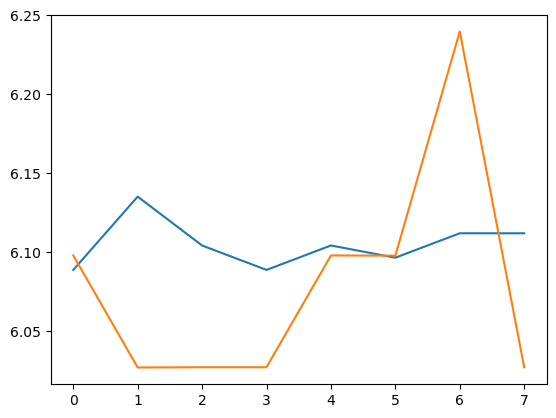

In [29]:
import matplotlib.pyplot as plt

plt.plot(result)
plt.plot(result2)
plt.show()

overfitting ? ...